### Code from asian_fixed_ML (trying to get density_estimation(), but not working yet)

In [6]:
import qmcpy as qp
from qmcpy import *
import numpy as np
import math
import pandas as pd
from pandas import *
import math as math
import scipy as sc
from sympy import *
pd.options.display.float_format = '{:.2e}'.format
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from scipy.stats import norm
from qmcpy.discrete_distribution._discrete_distribution import LD
from qmcpy.accumulate_data import MLQMCData
from qmcpy.integrand import  MLCallOptions
import time as t
from scipy.special import erf
from qmcpy.integrand import Integrand
from qmcpy.discrete_distribution import DigitalNetB2
from qmcpy.true_measure import Gaussian
from qmcpy.util import ParameterError, MaxSamplesWarning, ParameterError, MaxLevelsWarning
import warnings
import array
from numpy.linalg import lstsq
from qmcpy.accumulate_data import AccumulateData

In [7]:
level_dims = [2,4,8]
ac2_multilevel = AsianOption(DigitalNetB2(seed=7),multilevel_dims=level_dims)
levels_to_spawn = np.arange(ac2_multilevel.max_level+1)
ac2_single_levels = ac2_multilevel.spawn(levels_to_spawn)
yml = 0
for ac2_single_level in ac2_single_levels:
    x = ac2_single_level.discrete_distrib.gen_samples(2**12)
    level_est = ac2_single_level.f(x).mean()
    yml += level_est
yml

1.7798714253755274

In [8]:
class FMLAsianOption(Integrand):

    def __init__(self, sampler, volatility=.2, option='asian', start_price=100.,
        strike_price=100., interest_rate=.05, t_final=1., _level=0, 
                 call_put='call', mean_type='arithmetic', multilevel_dims=[4,16,64]):
        
        self.ac2_multilevel = AsianOption(sampler, multilevel_dims=multilevel_dims, volatility=volatility, option=option, start_price=start_price,
        strike_price=strike_price, interest_rate=interest_rate, t_final=t_final, _level=_level, 
                 call_put=call_put, mean_type=mean_type)
        
        super(FMLAsianOption,self).__init__(dimension_indv=len(multilevel_dims),dimension_comb=1,parallel=False) # super = inhereting
    
    def g(self, t, *args):
        y=np.zeros((len(t), self.t_indv))
        for k in range (self.d_indv):
            d=self.ac2_multilevel[k].true_measure.d
            y[:,k]=self.ac2_multilevel[k].g(t[:,])

In [4]:
seed = 7

### Code from density_estimation: 

In [11]:
class RQMCEstimator:
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol'):
        #self.g=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
        self.n=n # number of paths (Quasi-monte carlo samples)
        self.h=h # bandwidth
        self.k=k # kernel
        if sequence=='Sobol':
            self.sampler=Sobol(1).gen_samples(n)
            
        elif sequence=='Lattice':
            self.sampler=Lattice(1).gen_samples(n)
            
        else:
            raise ValueError("Invalid input. Must be Sobol or Lattice")  
    
    def mise(self):
        est=np.squeeze(self.density_estimation())
        real_distrib=self.gaussian(self.points,2, 1) # we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise
    
    
    
class OptionEstimator(RQMCEstimator): # inherets from RQMCEstimator class above
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol', K=30, S0=50, T=1,
                 option='EPO'):
        # T = maturity time (in years)
        # K = spike price (stock price at maturity time)
        # r = interest rate (reflects inflation)
        # Sigma = volatility
        # S_0 = initial stock price

        super().__init__(n, h,k,sequence)
        self.option=option
        if option=='ECO': 
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        elif option=='EPO':
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        else:
            raise ValueError("Invalid input. Must be ECO or EPO")
        self.n=n 
        self.h=h
        self.k=k
        self.s=lambda x:self.S0*np.exp((r-sigma**2/2)*self.T+sigma*np.sqrt(self.T)*sc.stats.norm.ppf(x))
    def density_estimation(self,x):
        if self.option=='ECO':
            f=zeros(len(x),1)
            g=np.maximum(self.s(self.sampler)-self.K,0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)         
        else:
            f=zeros(len(x),1)
            g=np.maximum(self.K-self.s(self.sampler),0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)
        plt.figure()
        plt.plot(r,f2)
        plt.title("Density estimation")
        plt.xlabel("x")
        plt.ylabel("pdf")
        plt.show()
        print("Lower bound of estimation interval (a) is:",a)
        print("Upper bound of estimation interval (b) is:",b)
        return f,a,b   
    def mise(self):
        est=np.squeeze(self.density_estimation())
        real_distrib=self.gaussian(self.points,2, 1) # we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise

In [35]:
from ._stopping_criterion import StoppingCriterion
from ..accumulate_data import LDTransformData
from ..util import MaxSamplesWarning, ParameterError, ParameterWarning, CubatureWarning
from ..integrand import Integrand
from numpy import *
from time import time
import warnings
import matplotlib.pyplot as plt
import scipy as sc

ImportError: attempted relative import with no known parent package

In [30]:
class _CubQMCLDG(StoppingCriterion):
    """
    Abstract class for CubQMC{LD}G where LD is a low discrepancy discrete distribution. 
    See subclasses for implementation differences for each LD sequence. 
    """

    def __init__(self, integrand, abs_tol, rel_tol, n_init, n_max, fudge, check_cone,
        control_variates, control_variate_means, update_beta, ptransform,
        coefv, allowed_levels, allowed_distribs, cast_complex, error_fun):
        self.parameters = ['abs_tol','rel_tol','n_init','n_max']
        # Input Checks
        self.abs_tol = float(abs_tol)
        self.rel_tol = float(rel_tol)
        m_min = log2(n_init)
        m_max = log2(n_max)
        if m_min%1 != 0. or m_min < 8. or m_max%1 != 0.:
            warning_s = '''
                n_init and n_max must be a powers of 2.
                n_init must be >= 2^8.
                Using n_init = 2^10 and n_max=2^35.'''
            warnings.warn(warning_s, ParameterWarning)
            m_min = 10.
            m_max = 35.
        self.n_init = 2.**m_min
        self.n_max = 2.**m_max
        self.m_min = m_min
        self.m_max = m_max
        self.fudge = fudge
        self.check_cone = check_cone
        self.coefv = coefv
        self.ptransform = ptransform
        self.cast_complex = cast_complex
        self.error_fun = error_fun
        self.integrand = integrand
        self.true_measure = self.integrand.true_measure
        self.discrete_distrib = self.integrand.discrete_distrib
        self.d = self.discrete_distrib.d
        self.d_indv = self.integrand.d_indv
        self.cv = list(atleast_1d(control_variates))
        self.ncv = len(self.cv)
        self.cv_mu = array(control_variate_means) if self.ncv>0 else empty((self.ncv,)+self.d_indv)
        self.cv_mu = self.cv_mu if self.cv_mu.ndim>1 else self.cv_mu.reshape(self.ncv,-1)
        if self.cv_mu.shape!=((self.ncv,)+self.d_indv):
            raise ParameterError('''Control variate means should have shape (len(control variates),d_indv).''')
        for cv in self.cv:
            if (cv.discrete_distrib!=self.discrete_distrib) or (not isinstance(cv,Integrand)) or (cv.d_indv!=self.d_indv):
                raise ParameterError('''
                        Each control variates discrete distribution must be an Integrand instance 
                        with the same discrete distribution as the main integrand. d_indv must also match 
                        that of the main integrand instance for each control variate.''')
        self.update_beta = update_beta
        if self.ncv>0:
            self.parameters += ['cv','cv_mu','update_beta']
        super(_CubQMCLDG,self).__init__(allowed_levels, allowed_distribs, allow_vectorized_integrals=True)

    def integrate(self):
        t_start = time()
        self.datum = empty(self.d_indv,dtype=object)
        for j in ndindex(self.d_indv):
            cv_mu_j = self.cv_mu[(slice(None),)+j]
            self.datum[j] = LDTransformData(self.m_min,self.m_max,self.coefv,self.fudge,self.check_cone,self.ncv,cv_mu_j,self.update_beta)
        self.data = LDTransformData.__new__(LDTransformData)
        self.data.flags_indv = tile(False,self.d_indv)
        self.data.compute_flags = tile(True,self.d_indv)
        self.data.m = tile(self.m_min,self.d_indv)
        self.data.n_min = 0
        self.data.indv_bound_low = tile(-inf,self.d_indv)
        self.data.indv_bound_high = tile(inf,self.d_indv)
        self.data.solution_indv = tile(nan,self.d_indv)
        self.data.solution = nan
        self.data.xfull = empty((0,self.d))
        self.data.yfull = empty((0,)+self.d_indv)
        while True:
            m = self.data.m.max()
            n_min = self.data.n_min
            n_max = int(2**m)
            n = int(n_max-n_min)
            xnext = self.discrete_distrib.gen_samples(n_min=n_min,n_max=n_max)
            ycvnext = empty((1+self.ncv,n,)+self.d_indv,dtype=float)
            ycvnext[0] = self.integrand.f(xnext,periodization_transform=self.ptransform,compute_flags=self.data.compute_flags)
            for k in range(self.ncv):
                ycvnext[1+k] = self.cv[k].f(xnext,periodization_transform=self.ptransform,compute_flags=self.data.compute_flags)
            ycvnext_cp = ycvnext.astype(complex) if self.cast_complex else ycvnext.copy()
            for j in ndindex(self.d_indv):
                if self.data.flags_indv[j]: continue
                slice_yj = (0,slice(None),)+j
                slice_ygj = (slice(1,None),slice(None),)+j
                y_val = ycvnext[slice_yj]
                y_cp = ycvnext_cp[slice_yj]
                yg_val = ycvnext[slice_ygj].T
                yg_cp = ycvnext_cp[slice_ygj].T
                self.data.solution_indv[j],self.data.indv_bound_low[j],self.data.indv_bound_high[j],cone_violation = self.datum[j].update_data(m,y_val,y_cp,yg_val,yg_cp)
                if cone_violation:
                    warnings.warn('Function at index %d (indexing d_indv) violates cone conditions.'%j,CubatureWarning)
            self.data.xfull = vstack((self.data.xfull,xnext))
            self.data.yfull = vstack((self.data.yfull,ycvnext[0]))
            self.data.comb_bound_low,self.data.comb_bound_high = self.integrand.bound_fun(self.data.indv_bound_low,self.data.indv_bound_high)
            self.abs_tols,self.rel_tols = full_like(self.data.comb_bound_low,self.abs_tol),full_like(self.data.comb_bound_low,self.rel_tol)
            fidxs = isfinite(self.data.comb_bound_low)&isfinite(self.data.comb_bound_high)
            slow,shigh,abs_tols,rel_tols = self.data.comb_bound_low[fidxs],self.data.comb_bound_high[fidxs],self.abs_tols[fidxs],self.rel_tols[fidxs]
            self.data.solution = tile(nan,self.data.comb_bound_low.shape)
            self.data.solution[fidxs] = 1/2*(slow+shigh+self.error_fun(slow,abs_tols,rel_tols)-self.error_fun(shigh,abs_tols,rel_tols))
            self.data.comb_flags = tile(False,self.data.comb_bound_low.shape)
            self.data.comb_flags[fidxs] = (shigh-slow) < (self.error_fun(slow,abs_tols,rel_tols)+self.error_fun(shigh,abs_tols,rel_tols))
            self.data.flags_indv = self.integrand.dependency(self.data.comb_flags)
            self.data.compute_flags = ~self.data.flags_indv
            self.data.n = 2**self.data.m
            self.data.n_total = self.data.n.max()
            if sum(self.data.compute_flags)==0:
                break # stopping criterion met
            elif 2*self.data.n_total>self.n_max:
                # doubling samples would go over n_max
                warning_s = """
                Already generated %d samples.
                Trying to generate %d new samples would exceed n_max = %d.
                No more samples will be generated.
                Note that error tolerances may no longer be satisfied.""" \
                % (int(self.data.n_total),int(self.data.n_total),int(self.n_max))
                warnings.warn(warning_s, MaxSamplesWarning)
                break
            else:
                self.data.n_min = n_max
                self.data.m += self.data.compute_flags
        self.data.integrand = self.integrand
        self.data.true_measure = self.true_measure
        self.data.discrete_distrib = self.discrete_distrib
        self.data.stopping_crit = self
        self.data.parameters = [
            'solution',
            'comb_bound_low',
            'comb_bound_high',
            'comb_flags',
            'n_total',
            'n',
            'time_integrate']
        self.data.datum = self.datum
        self.data.time_integrate = time()-t_start
        return self.data.solution,self.data
    
    def set_tolerance(self, abs_tol=None, rel_tol=None):
        """
        See abstract method. 
        
        Args:
            abs_tol (float): absolute tolerance. Reset if supplied, ignored if not. 
            rel_tol (float): relative tolerance. Reset if supplied, ignored if not. 
        """
        if abs_tol != None: self.abs_tol = abs_tol
        if rel_tol != None: self.rel_tol = rel_tol

    def density_estimation(self):
        approx_solution, data = self.integrate()
        g=data.datum[0].y_val
        a=min(g)
        b=max(g)
        print("Lower bound of estimation interval (a) is:",a)
        print("Upper bound of estimation interval (b) is:",b)
        
        unique_values, counts = unique(g, return_counts=True)
        repeated_values = unique_values[counts > 1]# Find elements that are repeated (count > 1)
        values_cont=unique_values[counts==1]
        counts=counts[counts > 1]/len(g) #probability of each discrete value
        prob=len(values_cont)/len(g) #probability of being continous
        kde=sc.stats.gaussian_kde(values_cont.T)
        z=linspace(a,b,100)
            
        pdf_est=kde.evaluate(z.T)*prob
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('x')
        ax1.set_ylabel('Density', color=color)
        ax1.plot(z, pdf_est, color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        
        
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('Probability', color=color)  # we already handled the x-label with ax1
        plt.vlines(x=repeated_values, ymin=0, ymax=counts, colors='blue', lw=2, label='vline_single - full height')
        ax2.tick_params(axis='y', labelcolor=color)
        plt.show()
        return kde,a,b, approx_solution, data  

ImportError: attempted relative import with no known parent package

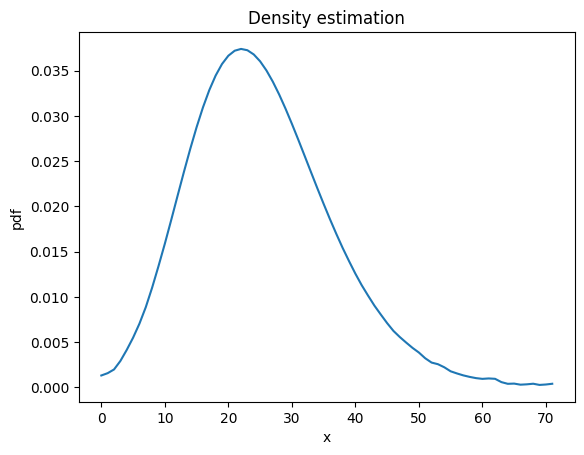

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [70.8487138]
Matrix([[0.00384078210742066]])


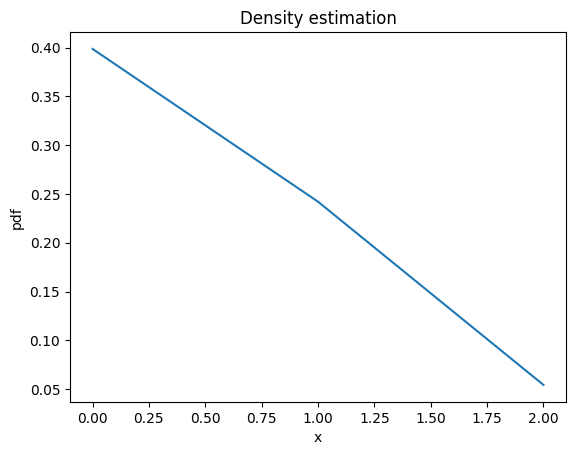

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [1.3374494]
Matrix([[0]])


In [12]:
# for this density function: partially discrete (probability of it being 0 is like 1/3, for instance), and partially continuous for any nonzero input
est=OptionEstimator(h=1, n=1024, option='ECO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x) # ECO: looks like a normal distribution, slightly skewed right, wider estimation interval
print(f[0]) 

est=OptionEstimator(h=1, n=1024, option='EPO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x) # EPO: looks like a neg-sloping line? narrower estimation interval
print(f[0])

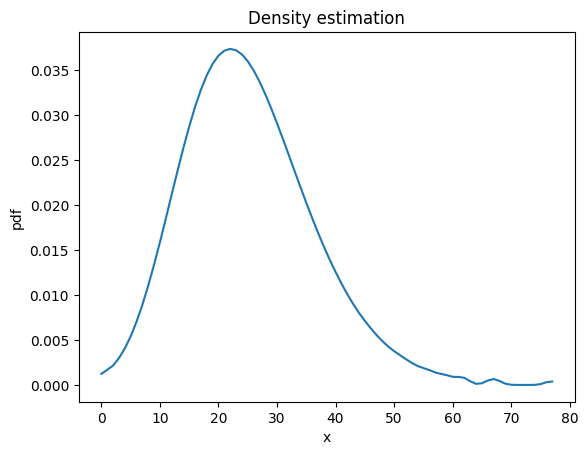

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [76.71434549]
Matrix([[0.00122767973952775], [0.00123418339018449], [0.00124064518545127], [0.00124706468521165], [0.00125344146991401], [0.00125977514079604], [0.00126606532009805], [0.00127231165126501], [0.00127851379913709], [0.00128467145012856], [0.00129078431239494], [0.00129685211598824], [0.00130287461300010], [0.00130885157769284], [0.00131478280661823], [0.00132066811872384], [0.00132650735544697], [0.00133230038079602], [0.00133804708141924], [0.00134374736666076], [0.00134940116860392], [0.00135500844210176], [0.00136056916479476], [0.00136608333711563], [0.00137155098228125], [0.00137697214627181], [0.00138234689779694], [0.00138767532824907], [0.00139295755164387], [0.00139819370454793], [0.00140338394599364], [0.00140852845738129], [0.00141362744236861], [0.00141868112674756], [0.00142368975830875], [0.00142865360669333], [0.00143357296323256], [0.00143844814077516], [0.0014432794

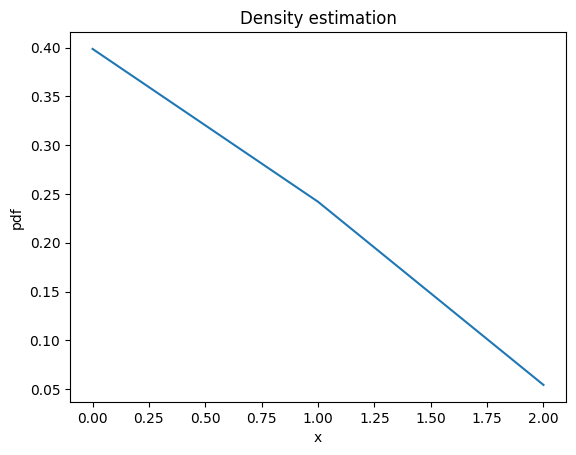

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [1.79578785]
Matrix([[0.398630374187039], [0.398611460446994], [0.398551907139353], [0.398451732954919], [0.398310969012725], [0.398129658844194], [0.397907858370749], [0.397645635875220], [0.397343071967056], [0.397000259541002], [0.396617303729898], [0.396194321850897], [0.395731443345860], [0.395228809715370], [0.394686574446838], [0.394104902936427], [0.393483972405258], [0.392823971809400], [0.392125101744197], [0.391387574342841], [0.390611613169163], [0.389797453104750], [0.388945340230662], [0.388055531703498], [0.387128295626296], [0.386163910913899], [0.385162667153350], [0.384124864459071], [0.383050813323034], [0.381940834460075], [0.380795258648502], [0.379614426565879], [0.378398688620364], [0.377148404777506], [0.375863944382910], [0.374545685980470], [0.373194017126661], [0.371809334200847], [0.370392042211850], [0.368942554600667], [0.367461293039826], [0.365948687229140], [0.364

In [34]:
# trying different sample size, looks about the same though

est=OptionEstimator(h=1, n=1024, option='ECO')
x=np.linspace(0,1,100)
# x=[50]
f=est.density_estimation(x) # ECO: looks like a normal distribution, slightly skewed right, wider estimation interval
print(f[0]) 

est=OptionEstimator(h=1, n=1024, option='EPO')
x=np.linspace(0,1,100)
# x=[50]
f=est.density_estimation(x) # EPO: looks like a neg-sloping line? narrower estimation interval
print(f[0])

In [15]:
level=1
aco = qp.AsianOption(qp.Sobol(2*2**level, seed=seed), volatility=.2, start_price=100, strike_price=150, interest_rate=.05, call_put='put')
kde,a,b, approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=1e-4).density_estimation()
print("European Option value: %.5f (to within 1e-4)"% approx_solution)

AttributeError: 'CubQMCSobolG' object has no attribute 'density_estimation'

# Comparison of multilevel (Quasi-)Monte Carlo for an Asian option problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/asian-option-mlqmc.ipynb)

Compute the exact value of the Asian option with single level QMC, for an increasing number of time steps:

In [3]:
for level in range(5):
    aco = qp.AsianOption(qp.Sobol(2*2**level, seed=seed), volatility=.2, start_price=100, strike_price=100, interest_rate=.05)
    approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=1e-4).integrate()
    print("Asian Option true value (%d time steps): %.5f (to within 1e-4)"%(2*2**level, approx_solution))

Asian Option true value (2 time steps): 5.63591 (to within 1e-4)
Asian Option true value (4 time steps): 5.73171 (to within 1e-4)
Asian Option true value (8 time steps): 5.75526 (to within 1e-4)
Asian Option true value (16 time steps): 5.76113 (to within 1e-4)
Asian Option true value (32 time steps): 5.76260 (to within 1e-4)


This function compares 4 different algorithms: Multilevel Monte Carlo (`CubMCML`), Multilevel Quasi-Monte Carlo (`CubQMCML`), continuation Multilevel Monte Carlo (`CubMCMLCont`) and Multilevel Quasi-Monte Carlo (`CubQMCMLCont`):

In [4]:
def eval_option(option_mc, option_qmc, abs_tol):
    stopping_criteria = {
        "MLMC" : qp.CubMCML(option_mc, abs_tol=abs_tol, levels_max=15),
        "continuation MLMC" : qp.CubMCMLCont(option_mc, abs_tol=abs_tol, levels_max=15),
        "MLQMC" : qp.CubQMCML(option_qmc, abs_tol=abs_tol, levels_max=15),
        "continuation MLQMC" : qp.CubQMCMLCont(option_qmc, abs_tol=abs_tol, levels_max=15)
    }
    
    levels = []
    times = []
    for name, stopper in stopping_criteria.items():
        sol, data = stopper.integrate()
        levels.append(data.levels)
        times.append(data.time_integrate)
        print("\t%-20s solution %-10.4f number of levels %-6d time %.3f"%(name, sol, levels[-1], times[-1]))
        
    return levels, times

Define the Multilevel Asian options:

In [5]:
option_mc = qp.MLCallOptions(qp.IIDStdUniform(seed=seed), option="asian")
option_qmc = qp.MLCallOptions(qp.Lattice(seed=seed), option="asian")

Run and compare each of the 4 algorithms for the Asian option problem:

In [6]:
eval_option(option_mc, option_qmc, abs_tol=5e-3);

	MLMC                 solution 5.7620     number of levels 10     time 45.993
	continuation MLMC    solution 5.7580     number of levels 7      time 30.715
	MLQMC                solution 5.7606     number of levels 8      time 19.286
	continuation MLQMC   solution 5.7594     number of levels 7      time 10.107


Repeat this comparison for a sequence of decreasing tolerances, with 5 different random seeds each. This will allow us to visualize the asymptotic cost complexity of each method.

In [12]:
repetitions = 5
tolerances = 5*np.logspace(-1, -3, num=5)

levels = {}
times = {}
for t in range(len(tolerances)):
    for r in range(repetitions):
        print("tolerance = %10.4e, repetition = %d/%d"%(tolerances[t], r + 1, repetitions))
        levels[t, r], times[t, r] = eval_option(option_mc, option_qmc, tolerances[t])

tolerance = 5.0000e-01, repetition = 1/5
	MLMC                 solution 5.5049     number of levels 3      time 0.008
	continuation MLMC    solution 5.6865     number of levels 3      time 0.008
	MLQMC                solution 5.7204     number of levels 3      time 0.474
	continuation MLQMC   solution 5.7099     number of levels 3      time 0.000
tolerance = 5.0000e-01, repetition = 2/5
	MLMC                 solution 5.7316     number of levels 4      time 0.008
	continuation MLMC    solution 5.6755     number of levels 4      time 0.016
	MLQMC                solution 5.7196     number of levels 3      time 0.508
	continuation MLQMC   solution 5.7014     number of levels 3      time 0.000
tolerance = 5.0000e-01, repetition = 3/5
	MLMC                 solution 5.6791     number of levels 3      time 0.001
	continuation MLMC    solution 5.8100     number of levels 3      time 0.010
	MLQMC                solution 5.6972     number of levels 3      time 0.453
	continuation MLQMC   solution

Compute and plot the asymptotic cost complexity.

In [8]:
avg_time = {}
for method in range(4):
    avg_time[method] = [np.mean([times[t, r][method] for r in range(repetitions)]) for t in range(len(tolerances))]

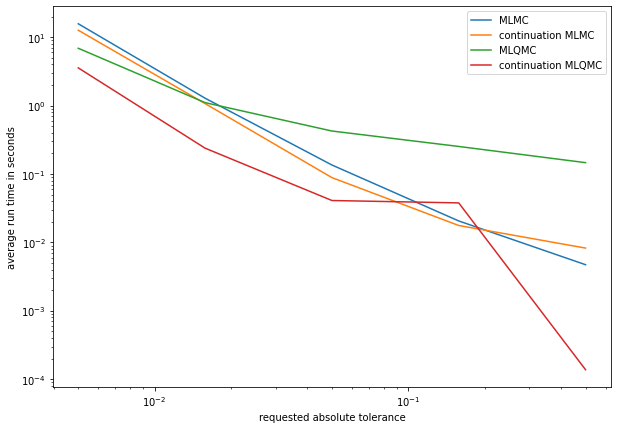

In [9]:
plt.figure(figsize=(10,7))
plt.plot(tolerances, avg_time[0], label="MLMC")
plt.plot(tolerances, avg_time[1], label="continuation MLMC")
plt.plot(tolerances, avg_time[2], label="MLQMC")
plt.plot(tolerances, avg_time[3], label="continuation MLQMC")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("requested absolute tolerance")
plt.ylabel("average run time in seconds")
plt.legend();

In [10]:
max_levels = {}
for method in range(4):
    levels_rep = np.array([levels[len(tolerances)-1, r][method] for r in range(repetitions)])
    max_levels[method] = [np.count_nonzero(levels_rep == level)/repetitions for level in range(15)]

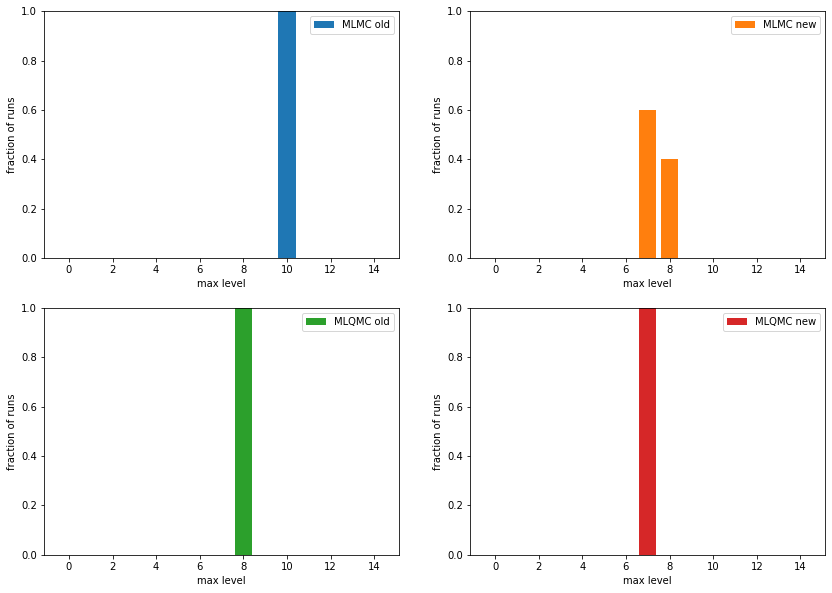

In [11]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1); plt.bar(range(15), max_levels[0], label="MLMC old", color="C0"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,2); plt.bar(range(15), max_levels[1], label="MLMC new", color="C1"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,3); plt.bar(range(15), max_levels[2], label="MLQMC old", color="C2"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,4); plt.bar(range(15), max_levels[3], label="MLQMC new", color="C3"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend();